# Import Library

In [27]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Load And Split Datasets

---
- Trước khi đưa dữ liệu vào mô hình huấn luyện phải tiền xử lí dữ liệu.
- Dữ liệu được tiền xử lí theo phương pháp:
    * Tạo một từ điển với 5000 từ thông dụng bằng `Tokenizer`.
    * Ánh xạ qua tập `train` để tạo một từ điển.
    * Ánh xạ tập `train` qua từ điển để tạo ra *vector* đầu vào cho mô hình.
    * Giới hạn từ trong một câu cho các vector đồng nhất (có thể cắt bớt hoặc thêm vào cho đủ câu).
    * Đưa vào tập huấn luyện.
---

In [18]:

# Load and Split Train Datasets

train = pd.read_csv('Fake_New_Classification/train.csv', delimiter=";")

X_train = train['title'].values + " " + train['text'].values
Y_train = train['label'].values

# Load and Split Test Datasets

test = pd.read_csv('Fake_New_Classification/test.csv', delimiter=";")

X_test = test['title'].values + " " + test['text'].values
Y_test = test['label'].values

# Load and Split Evaluations Datasets

eval = pd.read_csv('Fake_New_Classification/evaluation.csv', delimiter=";")

X_eval = eval['title'].values + " " + eval['text'].values
Y_eval = eval['label'].values


# Preprocessing Data

In [19]:

# Tokenizer Data

vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Tokenizer Data to Sequences

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
eval_sequences = tokenizer.texts_to_sequences(X_eval)

# Padding Sequences to Max Length

max_length = 300

pad_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
pad_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
pad_eval_sequences = pad_sequences(eval_sequences, maxlen=max_length, padding='post', truncating='post')

# Parameters

In [20]:
Latent_dim = 150
Batch_size = 128
epochs = 100

# CNN Model for NLP

In [21]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Phân loại nhị phân
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit(
        pad_train_sequences, Y_train,
        validation_data=(pad_eval_sequences, Y_eval),
        epochs=epochs,
        batch_size=Batch_size,
        callbacks=[early_stopping]
    )

Epoch 1/100
191/191 [==============================] - 38s 26ms/step - loss: 0.2103 - accuracy: 0.9104 - val_loss: 0.0490 - val_accuracy: 0.9805
Epoch 2/100
191/191 [==============================] - 5s 24ms/step - loss: 0.0369 - accuracy: 0.9869 - val_loss: 0.0388 - val_accuracy: 0.9846
Epoch 3/100
191/191 [==============================] - 5s 24ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.0415 - val_accuracy: 0.9846
Epoch 4/100
191/191 [==============================] - 5s 24ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.0443 - val_accuracy: 0.9844
Epoch 5/100
191/191 [==============================] - 5s 24ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0502 - val_accuracy: 0.9851


# Evaluate

In [23]:
loss, accuracy = model.evaluate(pad_test_sequences, Y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

254/254 [==============================] - 2s 6ms/step - loss: 0.0360 - accuracy: 0.9871
Test Loss: 0.0360, Test Accuracy: 0.9871


In [24]:
y_pred = (model.predict(pad_test_sequences) > 0.5).astype("int32")
print(classification_report(Y_test, y_pred))

254/254 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3753
           1       0.99      0.99      0.99      4364

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



In [25]:
model.save("fake_news_cnn.h5")

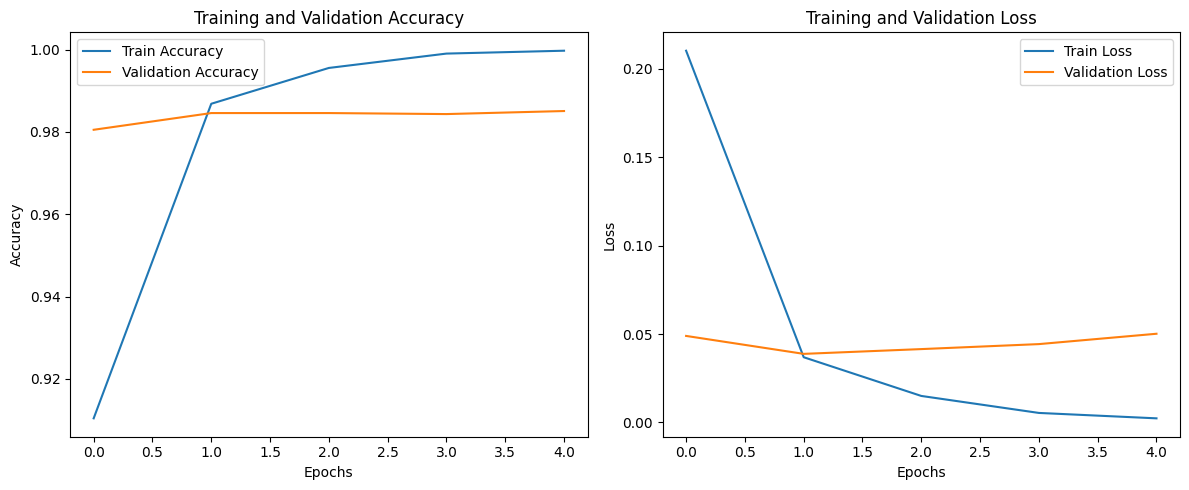

In [28]:
def plot_training_history(history):
    # Lấy dữ liệu từ lịch sử huấn luyện
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Vẽ biểu đồ độ chính xác
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Vẽ biểu đồ mất mát
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ biểu đồ
plot_training_history(history)

# Predict

In [26]:
def predict(texts, tokenizer, model, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded)
    return (predictions > 0.5).astype("int32")